In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import itertools

from utilities2015 import *

from joblib import Parallel, delayed

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

In [7]:
section_id = 100

dm = DataManager(stack='MD593', section=section_id,
                 labeling_dir='/home/yuncong/CSHL_data_labelings')

# dm._load_image()

texton_hists = dm.load_pipeline_result('texHist')
segmentation = dm.load_pipeline_result('segmentation')
n_superpixels = segmentation.max() + 1
textonmap = dm.load_pipeline_result('texMap')
n_texton = textonmap.max() + 1
neighbors = dm.load_pipeline_result('neighbors')

# neighbors_global = neighbors

# texture_map = texton_hists[segmentation]
# texture_map[~dm.mask] = np.nan * np.ones((n_texton,))
# dm.save_pipeline_result(texture_map, 'textureMap', 'npy')

# texture_map = dm.load_pipeline_result('textureMap', 'npy')

# coherence_map = dm.load_pipeline_result('coherenceMap', 'npy')
# eigenvec_map = dm.load_pipeline_result('eigenvecMap', 'npy')

# origPosCanvas = dm.load_pipeline_result('originPosOnCanvas', 'npy')

In [8]:
labeling_name = 'MD593_0100_yuncong_09202015173615'
labeling = dm.load_labeling(labeling_name='_'.join(labeling_name.split('_')[-2:]))

In [9]:
thetas = np.linspace(-np.pi/8, np.pi/8, 3)
n_theta = len(thetas)
Rs = [np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) for theta in thetas]

scales = np.linspace(.8, 1.2, 3)
n_scales = len(scales)

In [10]:
def find_in_polygon_coords(vertices):

    from matplotlib.path import Path

    xmin, ymin = vertices.min(axis=0)
    xmax, ymax = vertices.max(axis=0)
    
    X, Y = np.meshgrid(range(xmin, xmax+1), range(ymin, ymax+1))
    all_coords = np.c_[X.flat, Y.flat]
    
    mpath = Path(vertices) # the vertices of the polygon
    mask_flat = mpath.contains_points(all_coords)
    return all_coords[mask_flat]

def compute_landmark_descriptors2(group):
    polygon_type, vertices_global = group[0]
    vertices_global = vertices_global.astype(np.int)

    if polygon_type != PolygonType.TEXTURE_WITH_CONTOUR and polygon_type != PolygonType.TEXTURE:
        return {}
    
#     xmin, ymin = vertices_global.min(axis=0).astype(np.int)
#     xmax, ymax = vertices_global.max(axis=0).astype(np.int)
    
    coords = find_in_polygon_coords(vertices_global)
    c = coords.mean(axis=0)

    coords0 = coords - c
    U,S,V = np.linalg.svd(np.dot(coords0.T, coords0)/coords0.shape[0])
    v1 = U[:,0]
    v2 = U[:,1]
    s1 = np.sqrt(S[0])
    s2 = np.sqrt(S[1])
    
#     ellipse_angle = np.rad2deg(np.arctan2(v1[1], v1[0]))

    hist = np.bincount([l for l in textonmap[coords[:,1], coords[:,0]] if l != -1], minlength=n_texton)
    hist = hist/float(hist.sum())

    descriptor_variations = []
    
    for theta_i in range(n_theta):

        v1t = np.dot(Rs[theta_i], v1)
        v2t = np.dot(Rs[theta_i], v2)

        for scale_i in range(n_scales):
#             print theta_i, scale_i
            
#             t = time.time()
            vertices_global_deformed = (np.dot(vertices_global - c, Rs[theta_i].T) * scales[scale_i] 
                                       + c).astype(np.int)        
            
            coords = find_in_polygon_coords(vertices_global_deformed).astype(np.int16)
            coords0 = (coords - c).astype(np.int16)
            
            s1t = scales[scale_i] * s1
            s2t = scales[scale_i] * s2
            
#             U,S,V = np.linalg.svd(np.dot(coords0.T, coords0)/coords0.shape[0])
#             v1 = U[:,0]
#             v2 = U[:,1]
#             s1 = np.sqrt(S[0])
#             s2 = np.sqrt(S[1])
            
            ellipse_angle = np.rad2deg(np.arctan2(v1t[1], v1t[0]))
        
            xmin, ymin = vertices_global_deformed.min(axis=0).astype(np.int)
            xmax, ymax = vertices_global_deformed.max(axis=0).astype(np.int)
            width = xmax - xmin + 1
            height = ymax - ymin + 1

            mask = np.zeros((height, width), np.bool)
            coords1 = coords - (xmin, ymin)
            mask[coords1[:,1], coords1[:,0]] = True
            
            descriptor = \
            {'centroid_global': c,
             'mask': mask,
#              'coords_local': coords0,
#              'coords_global': coords,
             'vertices_global': vertices_global,
             'v1': v1t,
             'v2': v2t,
             's1': s1t,
             's2': s2t,
             'hist': hist,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
             'height':height,
             'width': width,
             'ellipse_angle': ellipse_angle,
             'mask_xmin': xmin - c[0].astype(np.int),
             'mask_ymin': ymin - c[1].astype(np.int),
             'mask_xmax': xmax - c[0].astype(np.int),
             'mask_ymax': ymax - c[1].astype(np.int),
             'centroid_local': c - (xmin, ymin)
            }

            descriptor_variations.append(descriptor)
            
#             print time.time()-t
            
    return descriptor_variations    

In [11]:
d = compute_landmark_descriptors2(labeling['final_polygons'][3])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


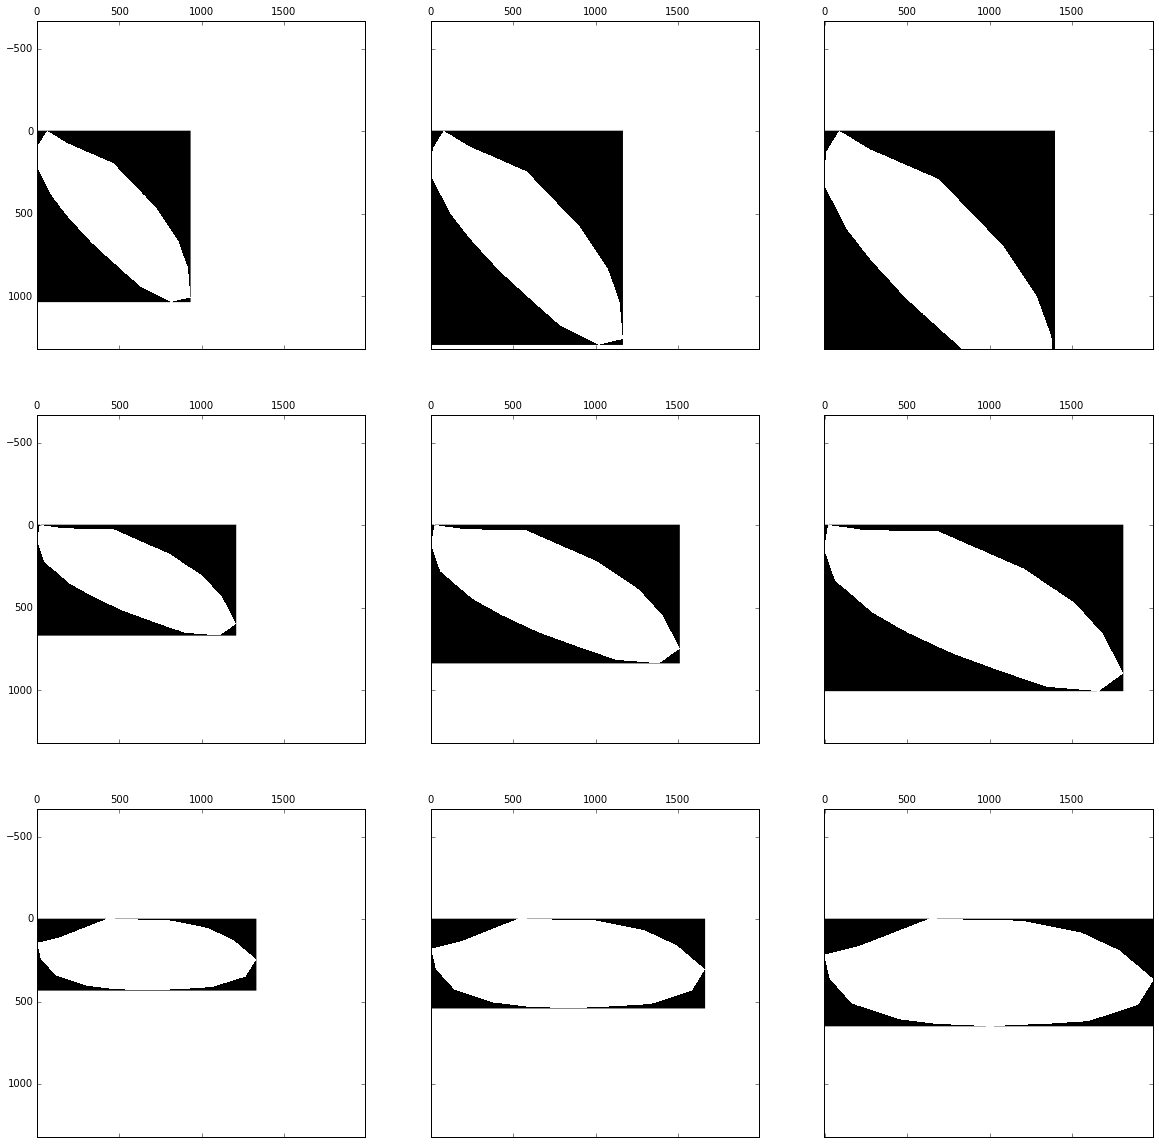

In [12]:
# from matplotlib.patches import Ellipse

fig, axes = plt.subplots(n_theta, n_scales, figsize=(20,20), sharex='all', sharey='all')

for angle_i, scale_i in itertools.product(range(n_theta), range(n_scales)):
# for angle_i, scale_i in itertools.product(range(1), range(1)):

    dd = d[n_scales * angle_i + scale_i]
    
#     mask = np.zeros((dd['height'], dd['width']), np.bool)
#     coords = dd['coords_global'] - (dd['xmin'], dd['ymin'])
#     mask[coords[:,1], coords[:,0]] = True
#     axes[angle_i, scale_i].matshow(mask, cmap=plt.cm.gray)

#     el = Ellipse(dd['centroid_global'], 2*dd['s1']*1.5, 2*dd['s2']*1.5, dd['ellipse_angle'], fill=False)
#     axes[angle_i, scale_i].add_patch(el)
#     axes[angle_i, scale_i].set_xlim(dd['xmin'], dd['xmax'])
#     axes[angle_i, scale_i].set_ylim(dd['ymin'], dd['ymax'])    
#     axes[angle_i, scale_i].set(aspect='equal')
#     axes[angle_i, scale_i].invert_yaxis()

    axes[angle_i, scale_i].matshow(dd['mask'], cmap=plt.cm.gray);

fig.show()

In [20]:
d[4]['xmin']

8527

[ 0.0439815   0.05535352  0.03582803  0.00434519  0.04065732  0.12972202
  0.06677689  0.29048385  0.0729602   0.05146456  0.03889695  0.02379733
  0.04489689  0.10083574]


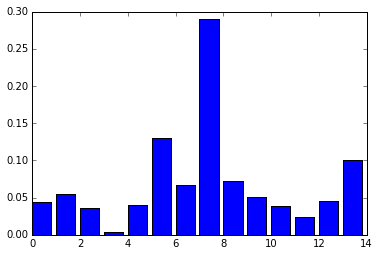

In [18]:
print d[0]['hist']
plt.bar(range(n_texton), d[0]['hist']);

In [22]:
descriptor = {}
for label, group in labeling['final_polygons'].iteritems():
    print label
    descriptor = compute_landmark_descriptors2(group)
    with open('/home/yuncong/csd395/CSHL_data_landmarks/%s_landmark_%d.pkl'%(labeling_name, label), 'w') as f:
        pickle.dump(descriptor, f)

0
1
2
3
4
5
